In [130]:
import missingno as msno
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from ycimpute.imputer import iterforest
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [51]:
data = pd.read_csv('Dataset.csv')
df = pd.DataFrame(data)
df.shape

(322, 20)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [53]:
df.head(10)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
6,185,37,1,23,8,21,2,214,42,1,30,9,24,N,E,76,127,7,70.0,A
7,298,73,0,24,24,7,3,509,108,0,41,37,12,A,W,121,283,9,100.0,A
8,323,81,6,26,32,8,2,341,86,6,32,34,8,N,W,143,290,19,75.0,N
9,401,92,17,49,66,65,13,5206,1332,253,784,890,866,A,E,0,0,0,1100.0,A


In [54]:
# One hot encoding
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dms.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
0,1,0,1,0,1,0
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1


In [55]:
df = df.drop((df[['League', 'Division', 'NewLeague']]) ,axis = 1 )
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
0,293,66,1,30,29,14,1,293,66,1,30,29,14,446,33,20,NaN
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5


## Eksik Veri Analizi ( Missing Data Analysis )

In [56]:
df.isnull().sum().sum()

59

---
# Eksik Veri Rassalığın İncelenmesi
#### Eksik Veri Yapısının Görselleştirilme Tekniği İle İncelenmesi: 

<AxesSubplot:>

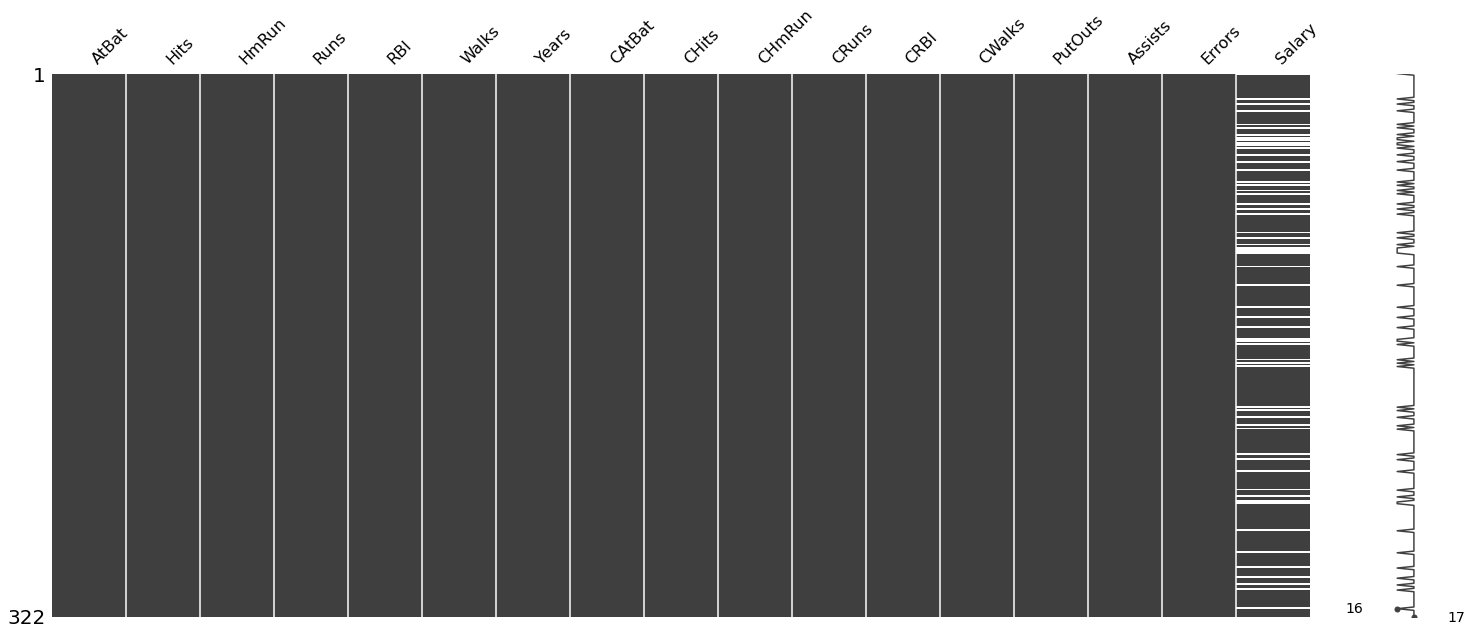

In [57]:
msno.matrix(df)

<AxesSubplot:>

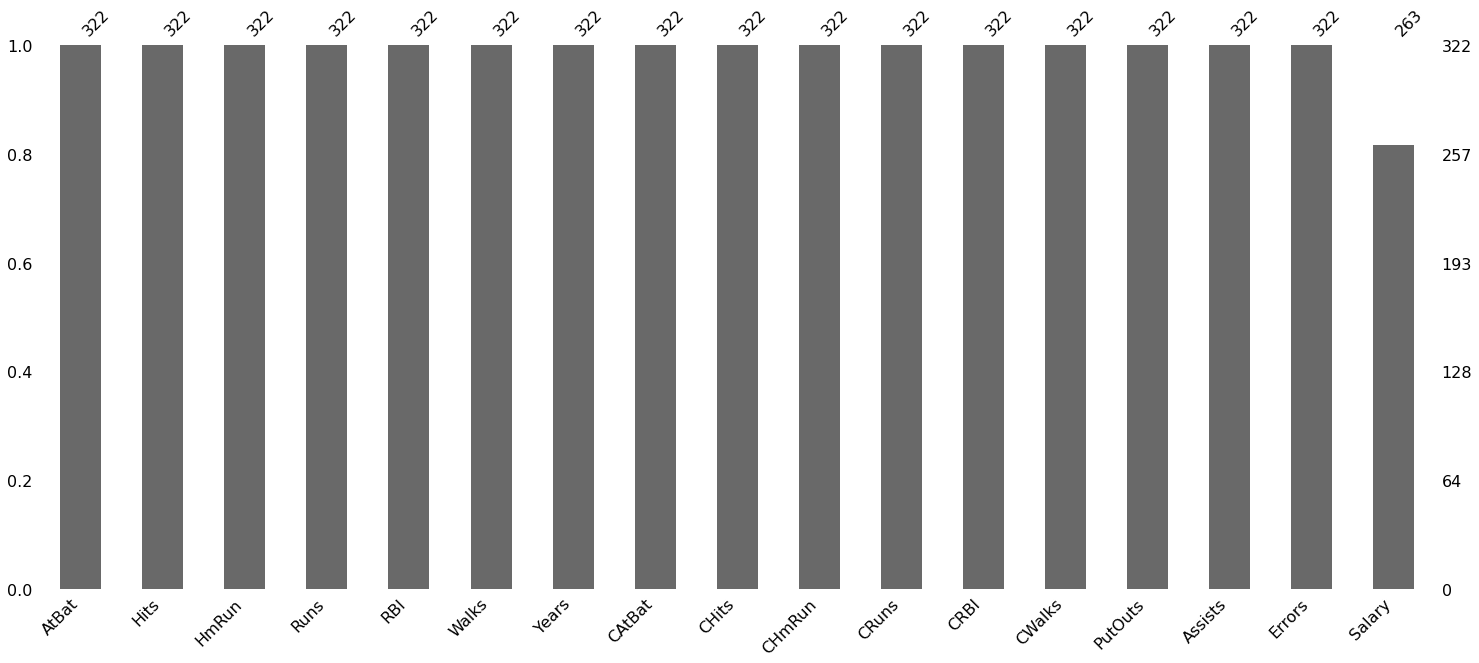

In [58]:
msno.bar(df)

* Yukarıda gözlemlendiği üzere: Rastlantısal Olmayan Kayıp durumu söz konusudur. Bu durum göz ardı edilemeyecek olan ve yapısal problemler ile ortaya çıkan eksilik türüdür.
* Eksik değere sahip gözlemlerin veri setinden direk çıkarılması ve rassallığının incelenmemesii yapılacak istatiksel çıkarımların, modelleme çalışmalarının güvenlirliğini düşürecektir. (Alpar, 2011)
* Bu kayıp silme yöntemi, tahmin yöntemi, değer atama yöntemi ile önlenebilir. Ancak yapılacak direkt atama yöntemi veya silme yöntemi ciddi yanlılıklara sebep olabilir. Bu nedenle bu çalışmamda ML tahmin yöntemi kullanarak bir atama gerçekleştirdim.
---

### ML Tahmine, Dayalı Değer Atama Yöntemi: 
**Random Forest Algorithm**
---

In [59]:
n_df = df.select_dtypes(include = ['float64', 'int64'])
print(n_df.head())

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks  PutOuts  Assists  Errors  Salary  
0    29      14      446       33      20     NaN  
1   414     375      632       43      10   475.0  
2   266     263      880       82      14   480.0  
3   838     354      200       11       3   500.0  
4    46      33      805       40       4    91.5  


In [60]:
column_names = list(n_df)
column_names

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'Salary']

In [61]:
n_df = np.array(n_df)
n_df

array([[ 293.,   66.,    1., ...,   33.,   20.,   nan],
       [ 315.,   81.,    7., ...,   43.,   10.,  475.],
       [ 479.,  130.,   18., ...,   82.,   14.,  480.],
       ...,
       [ 475.,  126.,    3., ...,  113.,    7.,  385.],
       [ 573.,  144.,    9., ...,  131.,   12.,  960.],
       [ 631.,  170.,    9., ...,    4.,    3., 1000.]])

In [62]:
dff = iterforest.IterImput().complete(n_df)

In [63]:
df = pd.DataFrame(dff, columns = column_names)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
0,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,66.0,1.0,30.0,29.0,14.0,446.0,33.0,20.0,77.565
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,475.000
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,480.000
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,500.000
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,91.500


In [64]:
df.isnull().sum()

AtBat      0
Hits       0
HmRun      0
Runs       0
RBI        0
Walks      0
Years      0
CAtBat     0
CHits      0
CHmRun     0
CRuns      0
CRBI       0
CWalks     0
PutOuts    0
Assists    0
Errors     0
Salary     0
dtype: int64

In [65]:
df.shape

(322, 17)

## Aykırı Gözlem Analizi (Outlier Analysis):
---
**Boxplot (interquartile Range - IQR) Yöntemi:**

<AxesSubplot:xlabel='Salary'>

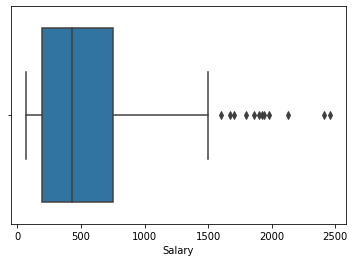

In [66]:
sns.boxplot(x = df['Salary'])

In [67]:
df[['Salary']].describe().T

,count,mean,std,min,25%,50%,75%,max
Salary,322.0,531.035026,436.606348,67.5,193.537515,430.199995,750.0,2460.0


In [68]:
Q1 = df['Salary'].quantile(0.25)
Q1

193.537515

In [69]:
Q3 = df['Salary'].quantile(0.75)
Q3

750.0

In [70]:
IQR = Q3 - Q1 
IQR

556.462485

In [71]:
lower_limit = Q1 - 1.5*IQR
lower_limit

-641.1562125

In [72]:
upper_limit = Q3 + 1.5*IQR
upper_limit

1584.6937275

In [73]:
df = df[~((df['Salary'] < lower_limit) | (df['Salary'] > upper_limit))]
df.shape

(310, 17)

<AxesSubplot:xlabel='Salary'>

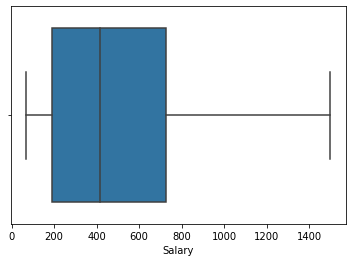

In [74]:
sns.boxplot(x = df['Salary'])

In [77]:
X = pd.concat([df, dms[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,66.0,1.0,30.0,29.0,14.0,446.0,33.0,20.0,77.565,0,0,0
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,475.000,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,480.000,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,500.000,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,91.500,1,0,1


<AxesSubplot:>

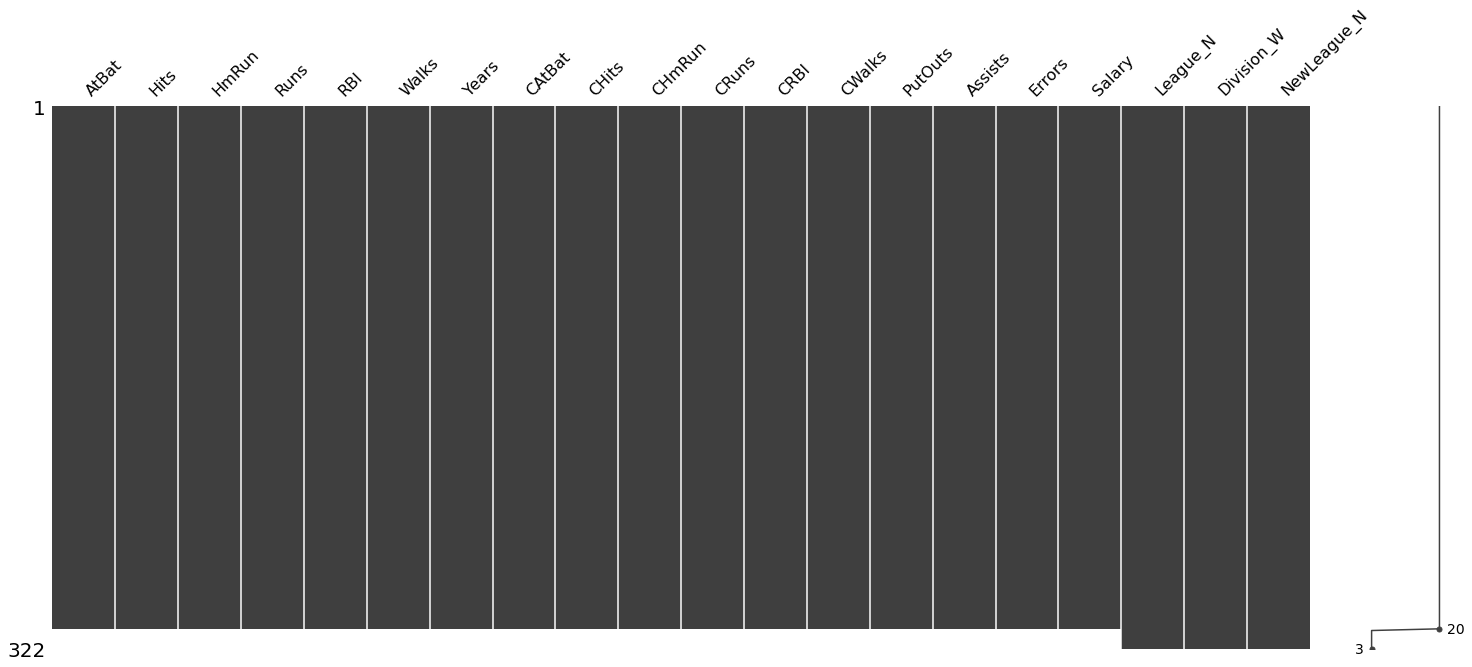

In [78]:
msno.matrix(X)

In [79]:
X.tail(20)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
314,408.0,117.0,11.0,66.0,41.0,34.0,1.0,408.0,117.0,11.0,66.0,41.0,34.0,942.0,72.0,11.0,120.00000,1,1,1
315,593.0,172.0,22.0,82.0,100.0,57.0,1.0,593.0,172.0,22.0,82.0,100.0,57.0,1222.0,139.0,15.0,165.00000,0,1,0
316,221.0,53.0,2.0,21.0,23.0,22.0,8.0,1063.0,283.0,15.0,107.0,124.0,106.0,325.0,58.0,6.0,283.12669,1,0,1
317,497.0,127.0,7.0,65.0,48.0,37.0,5.0,2703.0,806.0,32.0,379.0,311.0,138.0,325.0,9.0,3.0,700.00000,1,0,1
318,492.0,136.0,5.0,76.0,50.0,94.0,12.0,5511.0,1511.0,39.0,897.0,451.0,875.0,313.0,381.0,20.0,875.00000,0,0,0
319,475.0,126.0,3.0,61.0,43.0,52.0,6.0,1700.0,433.0,7.0,217.0,93.0,146.0,37.0,113.0,7.0,385.00000,0,1,0
320,573.0,144.0,9.0,85.0,60.0,78.0,8.0,3198.0,857.0,97.0,470.0,420.0,332.0,1314.0,131.0,12.0,960.00000,0,0,0
321,631.0,170.0,9.0,77.0,44.0,31.0,11.0,4908.0,1457.0,30.0,775.0,357.0,249.0,408.0,4.0,3.0,1000.00000,0,1,0
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1


In [80]:
X.dropna(inplace = True)
X.tail(10)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
311,360.0,81.0,5.0,37.0,44.0,37.0,7.0,2268.0,566.0,41.0,279.0,257.0,246.0,170.0,284.0,3.0,525.00000,1,0,1
312,387.0,124.0,1.0,67.0,27.0,36.0,7.0,1775.0,506.0,6.0,272.0,125.0,194.0,186.0,290.0,17.0,550.00000,1,0,1
314,408.0,117.0,11.0,66.0,41.0,34.0,1.0,408.0,117.0,11.0,66.0,41.0,34.0,942.0,72.0,11.0,120.00000,1,1,1
315,593.0,172.0,22.0,82.0,100.0,57.0,1.0,593.0,172.0,22.0,82.0,100.0,57.0,1222.0,139.0,15.0,165.00000,0,1,0
316,221.0,53.0,2.0,21.0,23.0,22.0,8.0,1063.0,283.0,15.0,107.0,124.0,106.0,325.0,58.0,6.0,283.12669,1,0,1
317,497.0,127.0,7.0,65.0,48.0,37.0,5.0,2703.0,806.0,32.0,379.0,311.0,138.0,325.0,9.0,3.0,700.00000,1,0,1
318,492.0,136.0,5.0,76.0,50.0,94.0,12.0,5511.0,1511.0,39.0,897.0,451.0,875.0,313.0,381.0,20.0,875.00000,0,0,0
319,475.0,126.0,3.0,61.0,43.0,52.0,6.0,1700.0,433.0,7.0,217.0,93.0,146.0,37.0,113.0,7.0,385.00000,0,1,0
320,573.0,144.0,9.0,85.0,60.0,78.0,8.0,3198.0,857.0,97.0,470.0,420.0,332.0,1314.0,131.0,12.0,960.00000,0,0,0
321,631.0,170.0,9.0,77.0,44.0,31.0,11.0,4908.0,1457.0,30.0,775.0,357.0,249.0,408.0,4.0,3.0,1000.00000,0,1,0


<AxesSubplot:>

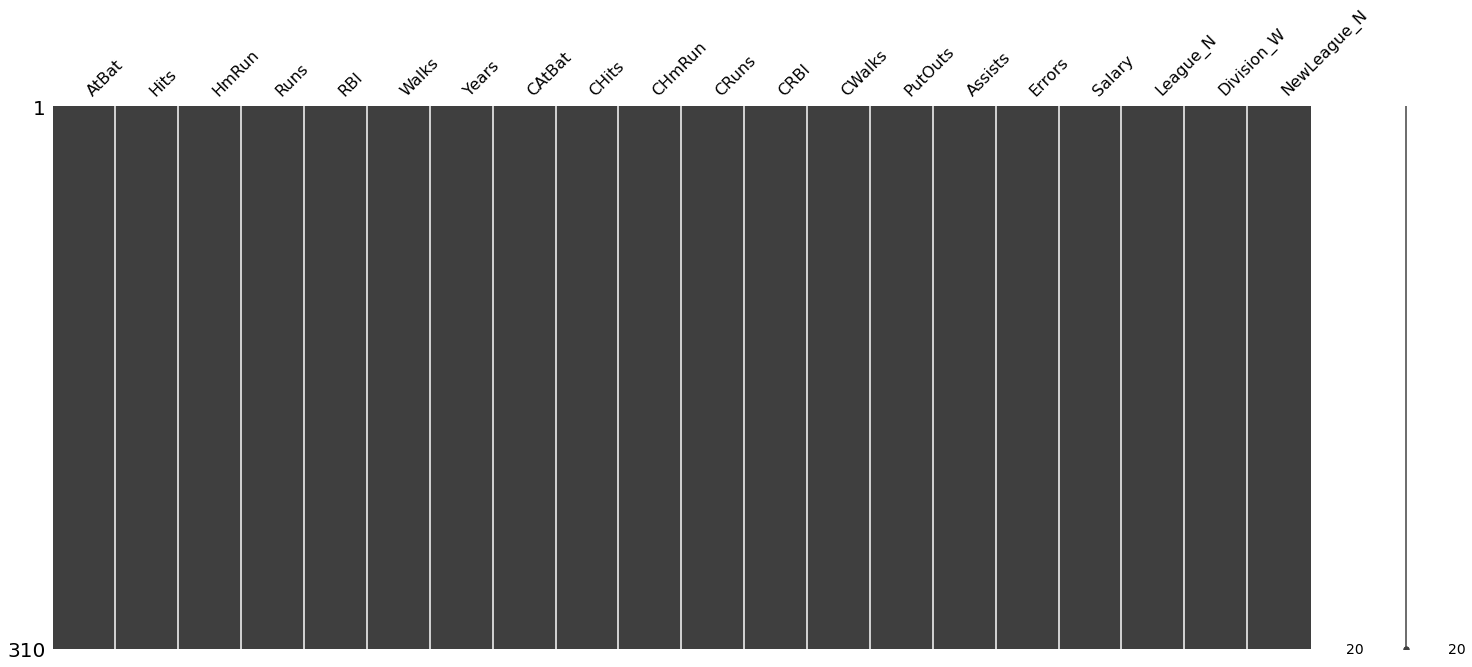

In [81]:
msno.matrix(X)

In [82]:
df = X

# Local Outlier Factor
---

In [83]:
LOF =LocalOutlierFactor(n_neighbors = 10) # k = 10
LOF.fit_predict(df)

array([ 1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [84]:
df_scores = LOF.negative_outlier_factor_
np.sort(df_scores)[0:30]

array([-4.63534046, -4.36527204, -4.09056083, -3.94149532, -3.26530579,
       -2.81898292, -2.5376952 , -2.52905272, -2.04360731, -1.81024783,
       -1.76661273, -1.60170693, -1.58616444, -1.57109882, -1.55741178,
       -1.46517785, -1.40164172, -1.33776333, -1.3339878 , -1.33293688,
       -1.31802503, -1.3070684 , -1.30640889, -1.30176852, -1.2920016 ,
       -1.28923725, -1.28410117, -1.26043524, -1.25619218, -1.2534235 ])

In [85]:
threshold_value = np.sort(df_scores)[3]
threshold_value

-3.941495324982449

In [86]:
outlier = df_scores > threshold_value
df = df[outlier]

In [87]:
df.shape

(306, 20)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 321
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        306 non-null    float64
 1   Hits         306 non-null    float64
 2   HmRun        306 non-null    float64
 3   Runs         306 non-null    float64
 4   RBI          306 non-null    float64
 5   Walks        306 non-null    float64
 6   Years        306 non-null    float64
 7   CAtBat       306 non-null    float64
 8   CHits        306 non-null    float64
 9   CHmRun       306 non-null    float64
 10  CRuns        306 non-null    float64
 11  CRBI         306 non-null    float64
 12  CWalks       306 non-null    float64
 13  PutOuts      306 non-null    float64
 14  Assists      306 non-null    float64
 15  Errors       306 non-null    float64
 16  Salary       306 non-null    float64
 17  League_N     306 non-null    uint8  
 18  Division_W   306 non-null    uint8  
 19  NewLeagu

In [90]:
df.isnull().sum()

AtBat          0
Hits           0
HmRun          0
Runs           0
RBI            0
Walks          0
Years          0
CAtBat         0
CHits          0
CHmRun         0
CRuns          0
CRBI           0
CWalks         0
PutOuts        0
Assists        0
Errors         0
Salary         0
League_N       0
Division_W     0
NewLeague_N    0
dtype: int64

In [112]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
0,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,66.0,1.0,30.0,29.0,14.0,446.0,33.0,20.0,77.565,0,0,0
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,475.000,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,480.000,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,500.000,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,91.500,1,0,1


In [ ]:
# Dependent Variable

In [114]:
dependent_ = df['Salary']

In [115]:
dependent_ = pd.DataFrame(dependent_)
dependent_.head()

,Salary
0,77.565
1,475.000
2,480.000
3,500.000
4,91.500


In [117]:
df = df.drop('Salary', axis = 1)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
0,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,66.0,1.0,30.0,29.0,14.0,446.0,33.0,20.0,0,0,0
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1


In [ ]:
# ML Algorithms

In [91]:
models = []

models.append(('SVR', SVR()))
models.append(('XGBoost', XGBRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RandomForests', RandomForestRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))

### Normalization

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    dependent_,
                                                    test_size = 0.25,
                                                    random_state = True)

In [129]:
for name,model in models:
    model = model.fit(X_train,Y_train.values.ravel())
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, predict))
    print('************************')
    print(name,rmse)
    print('************************')

************************
SVR 326.3345455020111
************************
************************
XGBoost 183.39541079095264
************************
************************
KNN 212.51587263554944
************************
************************
CART 236.6005949044905
************************
************************
RandomForests 171.0992426692714
************************
************************
GradientBoosting 167.87499516969598
************************
